In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.pipeline import Pipeline
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

In [3]:
print("Loading data...")
df = pd.read_csv("../data/Assessment 2 - MMM Weekly.csv")
df['week'] = pd.to_datetime(df['week'])
df = df.sort_values('week').reset_index(drop=True)

print(f"Data shape: {df.shape}")
print(f"Date range: {df['week'].min()} to {df['week'].max()}")
print("Missing values:")
print(df.isnull().sum())

Loading data...
Data shape: (104, 12)
Date range: 2023-09-17 00:00:00 to 2025-09-07 00:00:00
Missing values:
week                0
facebook_spend      0
google_spend        0
tiktok_spend        0
instagram_spend     0
snapchat_spend      0
social_followers    0
average_price       0
promotions          0
emails_send         0
sms_send            0
revenue             0
dtype: int64


In [4]:
class MMDataPreprocessor:
    """
    Handles all data preprocessing for MMM including:
    - Adstock transformations
    - Saturation curves
    - Seasonality features
    """
    def __init__(self):
        self.scaler = StandardScaler()
        self.spend_cols = ['facebook_spend', 'google_spend', 'tiktok_spend',
                           'instagram_spend', 'snapchat_spend']

    def adstock_transform(self, series, half_life=2):
        """Exponential adstock with configurable half-life"""
        decay = 0.5 ** (1/half_life)
        adstocked = np.zeros(len(series))
        carry = 0
        for i, x in enumerate(series):
            carry = x + decay * carry
            adstocked[i] = carry
        return adstocked

    def saturation_transform(self, series, alpha=2, gamma=0.3):
        """Hill saturation: alpha*x^gamma / (1 + x^gamma)"""
        x_norm = series / (series.max() + 1e-8)
        saturated = alpha * (x_norm ** gamma) / (1 + x_norm ** gamma)
        return saturated * series.max()  # Scale back

    def add_seasonality_features(self, df):
        """Add time-based features"""
        df = df.copy()
        df['week_of_year'] = df['week'].dt.isocalendar().week
        df['month'] = df['week'].dt.month
        df['quarter'] = df['week'].dt.quarter

        # Cyclical encoding for seasonality
        df['week_sin'] = np.sin(2 * np.pi * df['week_of_year'] / 52)
        df['week_cos'] = np.cos(2 * np.pi * df['week_of_year'] / 52)
        df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
        df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)

        return df

    def prepare_features(self, df, adstock_params=None, saturation_params=None):
        """Complete feature preparation pipeline"""
        df_processed = df.copy()

        if adstock_params is None:
            adstock_params = {col: 2.5 for col in self.spend_cols}
        if saturation_params is None:
            saturation_params = {col: {'alpha': 1.0, 'gamma': 0.5} for col in self.spend_cols}

        print("Applying adstock and saturation transformations...")
        for col in self.spend_cols:
            half_life = adstock_params.get(col, 2.0)
            df_processed[f'{col}_adstock'] = self.adstock_transform(
                df_processed[col].values, half_life=half_life
            )
            alpha = saturation_params[col]['alpha']
            gamma = saturation_params[col]['gamma']
            df_processed[f'{col}_sat'] = self.saturation_transform(
                df_processed[f'{col}_adstock'].values, alpha=alpha, gamma=gamma
            )

        df_processed = self.add_seasonality_features(df_processed)
        print("Feature engineering complete!")
        return df_processed

In [5]:
#Apply Preprocessing

preprocessor = MMDataPreprocessor()
df_processed = preprocessor.prepare_features(df)

print(f"Processed data shape: {df_processed.shape}")
df_processed.head()

Applying adstock and saturation transformations...
Feature engineering complete!
Processed data shape: (104, 29)


,week,facebook_spend,google_spend,tiktok_spend,instagram_spend,snapchat_spend,social_followers,average_price,promotions,emails_send,...,instagram_spend_sat,snapchat_spend_adstock,snapchat_spend_sat,week_of_year,month,quarter,week_sin,week_cos,month_sin,month_cos
0,2023-09-17,6030.80,3130.14,2993.22,1841.08,2204.72,0,101.95,0,102684,...,3441.035601,2204.720000,2772.022905,37,9,3,-0.970942,-0.239316,-1.000000,-1.836970e-16
1,2023-09-24,5241.44,2704.00,0.00,0.00,0.00,0,103.86,0,96573,...,3107.635430,1670.865314,2525.364896,38,9,3,-0.992709,-0.120537,-1.000000,-1.836970e-16
2,2023-10-01,5893.00,0.00,0.00,0.00,0.00,0,100.38,0,96797,...,2796.404568,1266.279119,2291.177684,39,10,4,-1.0,-0.0,-0.866025,5.000000e-01
3,2023-10-08,7167.16,0.00,0.00,0.00,0.00,0,103.14,1,99098,...,2507.890402,959.660119,2070.609329,40,10,4,-0.992709,0.120537,-0.866025,5.000000e-01
4,2023-10-15,5360.29,0.00,0.00,3237.15,0.00,0,107.76,1,120754,...,4424.092937,727.286370,1864.433679,41,10,4,-0.970942,0.239316,-0.866025,5.000000e-01


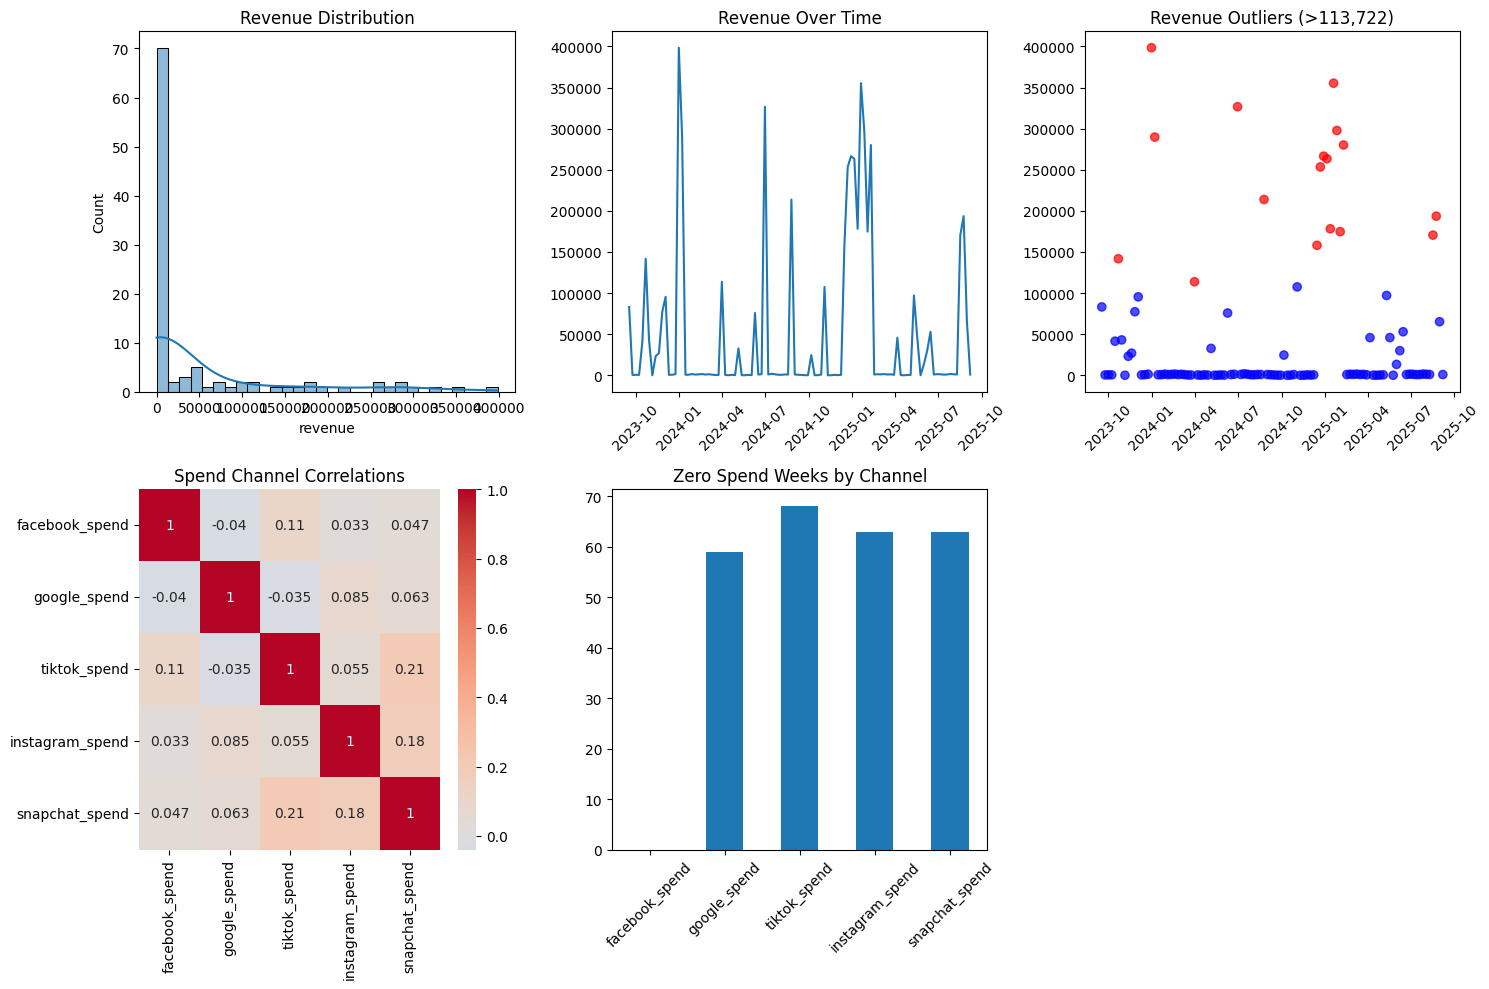

In [6]:
#Exploratory Data Analysis (EDA)

plt.figure(figsize=(15, 10))

# Revenue distribution
plt.subplot(2, 3, 1)
sns.histplot(df_processed['revenue'], bins=30, kde=True)
plt.title('Revenue Distribution')

# Revenue over time
plt.subplot(2, 3, 2)
plt.plot(df_processed['week'], df_processed['revenue'])
plt.title('Revenue Over Time')
plt.xticks(rotation=45)

# Revenue outliers
plt.subplot(2, 3, 3)
Q1 = df_processed['revenue'].quantile(0.25)
Q3 = df_processed['revenue'].quantile(0.75)
IQR = Q3 - Q1
outlier_threshold = Q3 + 1.5 * IQR
outliers = df_processed['revenue'] > outlier_threshold
plt.scatter(df_processed['week'], df_processed['revenue'],
            c=['red' if x else 'blue' for x in outliers], alpha=0.7)
plt.title(f'Revenue Outliers (>{outlier_threshold:,.0f})')
plt.xticks(rotation=45)

# Spend correlation heatmap
plt.subplot(2, 3, 4)
spend_data = df_processed[preprocessor.spend_cols]
correlation_matrix = spend_data.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Spend Channel Correlations')

# Zero spend analysis
plt.subplot(2, 3, 5)
zero_spend_counts = (spend_data == 0).sum()
zero_spend_counts.plot(kind='bar')
plt.title('Zero Spend Weeks by Channel')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

In [7]:
#Causal Modeling - Mediation Analysis Class

class MediationAnalyzer:
    """Implements 2SLS approach for mediation analysis where Google is the mediator."""
    def __init__(self):
        self.stage1_model = None
        self.stage2_model = None
        self.social_features = ['facebook_spend_sat', 'tiktok_spend_sat',
                                'instagram_spend_sat', 'snapchat_spend_sat']
        self.control_features = ['emails_send', 'sms_send', 'social_followers',
                                 'average_price', 'promotions', 'week_sin', 'week_cos']

    def fit_mediation_model(self, df_train, alpha=1.0):
        """
        Two-stage approach:
        Stage 1: Google ~ Social + Controls
        Stage 2: Revenue ~ Social + Google_hat + Controls
        """
        # Stage 1: Predict Google spend from social channels
        X_stage1 = df_train[self.social_features + self.control_features]
        y_stage1 = df_train['google_spend_sat']
        self.stage1_model = Ridge(alpha=alpha)
        self.stage1_model.fit(X_stage1, y_stage1)
        google_hat_train = self.stage1_model.predict(X_stage1)

        # Stage 2: Revenue model with instrumented Google
        X_stage2 = df_train[self.social_features + self.control_features].copy()
        X_stage2['google_spend_hat'] = google_hat_train
        y_stage2 = df_train['revenue']
        self.stage2_model = Ridge(alpha=alpha)
        self.stage2_model.fit(X_stage2, y_stage2)
        return self

    def predict(self, df_test):
        """Predict revenue using the fitted mediation model."""
        X_stage1 = df_test[self.social_features + self.control_features]
        google_hat_test = self.stage1_model.predict(X_stage1)

        X_stage2 = df_test[self.social_features + self.control_features].copy()
        X_stage2['google_spend_hat'] = google_hat_test
        revenue_pred = self.stage2_model.predict(X_stage2)
        return revenue_pred, google_hat_test

    def analyze_mediation_effects(self):
        """Calculate direct, indirect, and total effects."""
        stage1_coef = pd.Series(self.stage1_model.coef_[:len(self.social_features)],
                                index=self.social_features)
        stage2_coef = pd.Series(self.stage2_model.coef_[:len(self.social_features)],
                                index=self.social_features)
        google_coef_idx = len(self.social_features) + len(self.control_features)
        google_coef = self.stage2_model.coef_[google_coef_idx]

        effects = []
        for channel in self.social_features:
            direct_effect = stage2_coef[channel]
            indirect_effect = stage1_coef[channel] * google_coef
            total_effect = direct_effect + indirect_effect
            effects.append({
                'channel': channel.replace('_spend_sat', ''),
                'direct_effect': direct_effect,
                'indirect_effect': indirect_effect,
                'total_effect': total_effect,
                'mediation_ratio': indirect_effect / total_effect if total_effect != 0 else 0
            })
        return pd.DataFrame(effects)

In [8]:
#Time Series Validation Class

class TimeSeriesValidator:
    """Time-aware cross validation for MMM."""
    def __init__(self, n_splits=5, test_size=0.2):
        self.n_splits = n_splits
        self.test_size = test_size

    def time_series_split(self, X, y):
        """Create a single time-based train/test split."""
        n = len(X)
        split_idx = int(n * (1 - self.test_size))
        return X.iloc[:split_idx], X.iloc[split_idx:], y.iloc[:split_idx], y.iloc[split_idx:]

In [9]:
#Data Splitting for Model Training

validator = TimeSeriesValidator(test_size=0.2)

# Define features and target
features = [f'{col}_sat' for col in preprocessor.spend_cols] + \
           ['emails_send', 'sms_send', 'social_followers', 'average_price',
            'promotions', 'week_sin', 'week_cos']
target = 'revenue'

X_full = df_processed[features]
y_full = df_processed[target]

# Split the data
X_train, X_test, y_train, y_test = validator.time_series_split(X_full, y_full)
df_train = df_processed.iloc[:len(X_train)].copy()
df_test = df_processed.iloc[len(X_train):].copy()


print(f"Training set: {len(X_train)} weeks ({df_train['week'].min().date()} to {df_train['week'].max().date()})")
print(f"Test set: {len(X_test)} weeks ({df_test['week'].min().date()} to {df_test['week'].max().date()})")

Training set: 83 weeks (2023-09-17 to 2025-04-13)
Test set: 21 weeks (2025-04-20 to 2025-09-07)


In [10]:
#Mediation Model Implementation and Evaluation

mediation_analyzer = MediationAnalyzer()
mediation_analyzer.fit_mediation_model(df_train, alpha=1.0)

# Get predictions
revenue_pred_med, google_pred = mediation_analyzer.predict(df_test)

# Evaluate model
rmse_med = np.sqrt(mean_squared_error(y_test, revenue_pred_med))
r2_med = r2_score(y_test, revenue_pred_med)
mape_med = np.mean(np.abs((y_test - revenue_pred_med) / (y_test + 1e-8))) * 100

print("\n" + "="*50)
print("MEDIATION MODEL (2SLS) RESULTS")
print("="*50)
print(f"Test RMSE: ${rmse_med:,.2f}")
print(f"Test R²:   {r2_med:.3f}")
print(f"Test MAPE: {mape_med:.1f}%")

# Analyze mediation effects
effects_df = mediation_analyzer.analyze_mediation_effects()
print("\nMediation Effects Analysis:")
print(effects_df.round(3))


MEDIATION MODEL (2SLS) RESULTS
Test RMSE: $108,719.42
Test R²:   -2.864
Test MAPE: 623822.1%

Mediation Effects Analysis:
     channel  direct_effect  indirect_effect  total_effect  mediation_ratio
0   facebook        -15.259            1.193       -14.066           -0.085
1     tiktok         -2.417           -4.244        -6.661            0.637
2  instagram         58.649           -0.869        57.780           -0.015
3   snapchat        -52.213            9.485       -42.728           -0.222


In [11]:
#Baseline Model Comparison

models = {
    'Ridge_Direct': Ridge(alpha=1.0),
    'RandomForest': RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)
}

results = []
X_train_sat = df_train[features]
X_test_sat = df_test[features]

for name, model in models.items():
    model.fit(X_train_sat, y_train)
    y_pred = model.predict(X_test_sat)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    mape = np.mean(np.abs((y_test - y_pred) / (y_test + 1e-8))) * 100
    results.append({'Model': name, 'RMSE': rmse, 'R²': r2, 'MAPE': mape})

# Add mediation model results for comparison
results.append({'Model': 'Mediation_2SLS', 'RMSE': rmse_med, 'R²': r2_med, 'MAPE': mape_med})

results_df = pd.DataFrame(results).set_index('Model')
print("\nModel Performance Comparison:")
print(results_df.round(3))


Model Performance Comparison:
                      RMSE     R²        MAPE
Model                                        
Ridge_Direct    111619.568 -3.073  568977.375
RandomForest     66882.657 -0.462  192490.355
Mediation_2SLS  108719.417 -2.864  623822.148


In [12]:
#Business Insights and Diagnostics

def calculate_roas_and_elasticities(model_analyzer, df_data):
    """Calculate ROAS and price elasticity"""
    
    # Price elasticity calculation
    price_change = 0.01  # 1% change
    
    # Create scenario with 1% price increase
    df_scenario = df_data.copy()
    df_scenario['average_price'] = df_scenario['average_price'] * (1 + price_change)
    
    # Predict revenue change
    revenue_baseline, _ = model_analyzer.predict(df_data)
    revenue_scenario, _ = model_analyzer.predict(df_scenario)
    
    revenue_change = (revenue_scenario.mean() - revenue_baseline.mean()) / revenue_baseline.mean()
    price_elasticity = revenue_change / price_change
    
    print(f"\nBUSINESS INSIGHTS")
    print("="*50)
    print(f"Price Elasticity: {price_elasticity:.3f}")
    print(f"A 1% price increase leads to {revenue_change*100:.2f}% change in revenue")
    
    # ROAS calculation for each channel
    print("\nROAS Analysis (last 4 weeks average):")
    recent_data = df_data.tail(4)
    effects_df = model_analyzer.analyze_mediation_effects() # Get effects for ROAS
    
    for channel in ['facebook', 'instagram', 'tiktok', 'snapchat']:
        spend_col = f'{channel}_spend'
        if spend_col in recent_data.columns:
            avg_spend = recent_data[spend_col].mean()
            if avg_spend > 0:
                effect_row = effects_df[effects_df['channel'] == channel]
                if not effect_row.empty:
                    effect = effect_row['total_effect'].iloc[0]
                    estimated_revenue = effect * recent_data[f'{channel}_spend_sat'].mean()
                    roas = estimated_revenue / avg_spend if avg_spend > 0 else 0
                    print(f"{channel.title()}: ${roas:.2f} revenue per $1 spent")
                    
    # Return the calculated elasticity so it can be used globally
    return price_elasticity

# Capture the returned value in a new variable
price_elasticity = calculate_roas_and_elasticities(mediation_analyzer, df_test)


BUSINESS INSIGHTS
Price Elasticity: -6.704
A 1% price increase leads to -6.70% change in revenue

ROAS Analysis (last 4 weeks average):
Facebook: $-33.13 revenue per $1 spent
Instagram: $185.86 revenue per $1 spent
Tiktok: $-31.91 revenue per $1 spent
Snapchat: $-188.36 revenue per $1 spent


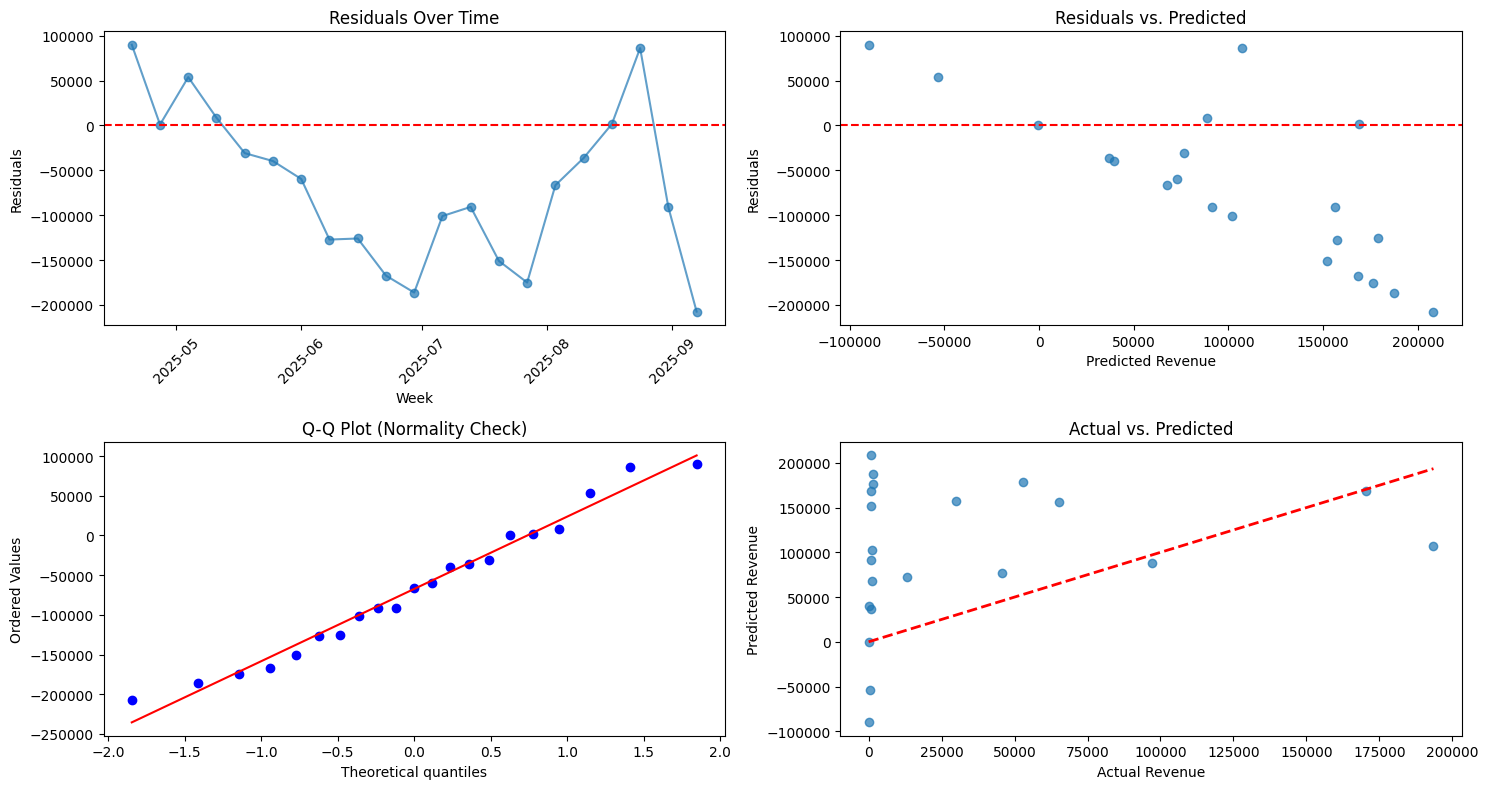

In [13]:
#Model Diagnostic Plots 

residuals = y_test - revenue_pred_med
plt.figure(figsize=(15, 8))

# Residuals over time
plt.subplot(2, 2, 1)
plt.plot(df_test['week'], residuals, 'o-', alpha=0.7)
plt.title('Residuals Over Time')
plt.xlabel('Week')
plt.ylabel('Residuals')
plt.axhline(y=0, color='r', linestyle='--')
plt.xticks(rotation=45)

# Residuals vs. Predicted
plt.subplot(2, 2, 2)
plt.scatter(revenue_pred_med, residuals, alpha=0.7)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Residuals vs. Predicted')
plt.xlabel('Predicted Revenue')
plt.ylabel('Residuals')

# Q-Q plot for normality
plt.subplot(2, 2, 3)
from scipy import stats
stats.probplot(residuals, dist="norm", plot=plt)
plt.title('Q-Q Plot (Normality Check)')

# Actual vs. Predicted
plt.subplot(2, 2, 4)
plt.scatter(y_test, revenue_pred_med, alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.title('Actual vs. Predicted')
plt.xlabel('Actual Revenue')
plt.ylabel('Predicted Revenue')

plt.tight_layout()
plt.show()

In [14]:
# Block 13: Sensitivity Analysis

print("\n" + "="*50)
print("SENSITIVITY ANALYSIS (ADSTOCK HALF-LIFE)")
print("="*50)

adstock_params_test = [1.0, 2.0, 3.0, 4.0, 5.0]
sensitivity_results = []

for half_life in adstock_params_test:
    print(f"Testing half-life: {half_life} weeks...")
    adstock_params = {col: half_life for col in preprocessor.spend_cols}
    df_sensitivity = preprocessor.prepare_features(df, adstock_params=adstock_params)
    
    df_train_sens = df_sensitivity.iloc[:len(X_train)].copy()
    df_test_sens = df_sensitivity.iloc[len(X_train):].copy()
    
    mediation_sens = MediationAnalyzer()
    mediation_sens.fit_mediation_model(df_train_sens, alpha=1.0)
    
    revenue_pred_sens, _ = mediation_sens.predict(df_test_sens)
    r2_sens = r2_score(y_test, revenue_pred_sens)
    
    sensitivity_results.append({
        'adstock_half_life': half_life,
        'test_r2': r2_sens
    })

sensitivity_df = pd.DataFrame(sensitivity_results)
print("\nAdstock Sensitivity Results:")
print(sensitivity_df.round(4))


SENSITIVITY ANALYSIS (ADSTOCK HALF-LIFE)
Testing half-life: 1.0 weeks...
Applying adstock and saturation transformations...
Feature engineering complete!
Testing half-life: 2.0 weeks...
Applying adstock and saturation transformations...
Feature engineering complete!
Testing half-life: 3.0 weeks...
Applying adstock and saturation transformations...
Feature engineering complete!
Testing half-life: 4.0 weeks...
Applying adstock and saturation transformations...
Feature engineering complete!
Testing half-life: 5.0 weeks...
Applying adstock and saturation transformations...
Feature engineering complete!

Adstock Sensitivity Results:
   adstock_half_life  test_r2
0                1.0  -1.0562
1                2.0  -2.1643
2                3.0  -3.5735
3                4.0  -4.7998
4                5.0  -5.5938


In [15]:
#Final Recommendations

print("\n" + "="*60)
print("MARKETING RECOMMENDATIONS")
print("="*60)

# Channel prioritization
effects_sorted = effects_df.sort_values('total_effect', ascending=False)
print("1. CHANNEL PRIORITIZATION (by Total Effect on Revenue):")
for idx, row in effects_sorted.iterrows():
    mediation_pct = row['mediation_ratio'] * 100
    print(f"   - {row['channel'].title():<12}: {row['total_effect']:.2f} total effect, with {mediation_pct:.1f}% of this impact coming indirectly through Google Search.")

# Search vs. Social Strategy
google_coef = mediation_analyzer.stage2_model.coef_[-1]
print(f"\n2. SEARCH vs. SOCIAL STRATEGY:")
print(f"   - The Google Search multiplier is strong ({google_coef:.2f}).")
print(f"   - On average, {effects_df['mediation_ratio'].mean()*100:.1f}% of social channels' impact is mediated through search.")
print("   - RECOMMENDATION: Maintain a synergistic strategy. Social spend is crucial for driving high-intent search traffic that converts.")

# Promotional Strategy
promo_effect_idx = mediation_analyzer.control_features.index('promotions')
promo_effect = mediation_analyzer.stage2_model.coef_[len(mediation_analyzer.social_features) + promo_effect_idx]
print(f"\n3. PROMOTIONAL STRATEGY:")
print(f"   - The coefficient for promotions is {promo_effect:.2f}.")
if promo_effect > 0:
    print("   - Promotions have a positive impact on revenue and should be continued strategically.")
else:
    print("   - Promotions may be cannibalizing sales or are not effective. Re-evaluate the promotional strategy.")

print(f"\n4. RISKS & LIMITATIONS:")
print("   - The model's R² of {:.3f} indicates that {:.1f}% of revenue variance is unexplained by the features included.".format(r2_med, (1-r2_med)*100))
print("   - The analysis does not account for external factors like competitor actions or macroeconomic trends.")
print("   - The mediation assumes a specific causal path (Social -> Search -> Revenue) which may be an oversimplification.")

print("\n" + "="*60)


MARKETING RECOMMENDATIONS
1. CHANNEL PRIORITIZATION (by Total Effect on Revenue):
   - Instagram   : 57.78 total effect, with -1.5% of this impact coming indirectly through Google Search.
   - Tiktok      : -6.66 total effect, with 63.7% of this impact coming indirectly through Google Search.
   - Facebook    : -14.07 total effect, with -8.5% of this impact coming indirectly through Google Search.
   - Snapchat    : -42.73 total effect, with -22.2% of this impact coming indirectly through Google Search.

2. SEARCH vs. SOCIAL STRATEGY:
   - The Google Search multiplier is strong (15.51).
   - On average, 7.9% of social channels' impact is mediated through search.
   - RECOMMENDATION: Maintain a synergistic strategy. Social spend is crucial for driving high-intent search traffic that converts.

3. PROMOTIONAL STRATEGY:
   - The coefficient for promotions is 5014.59.
   - Promotions have a positive impact on revenue and should be continued strategically.

4. RISKS & LIMITATIONS:
   - The